Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


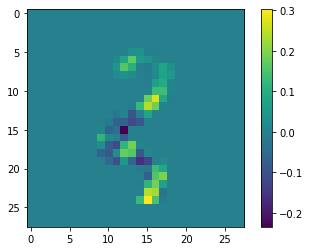

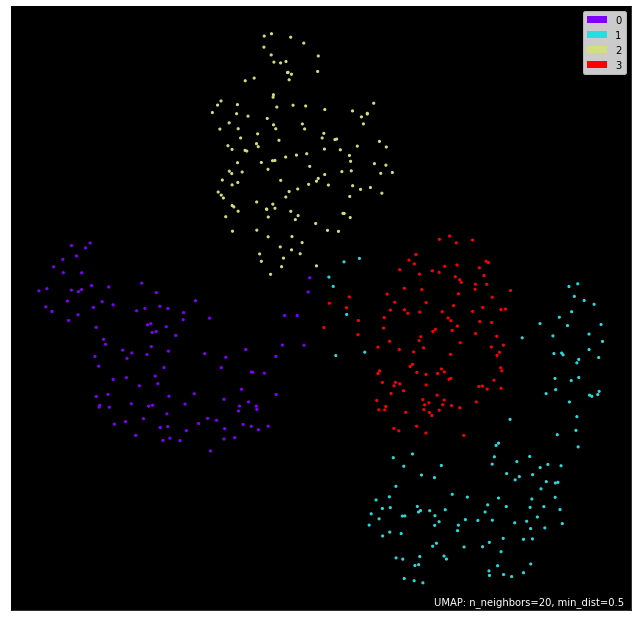

In [ ]:
from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

from google.colab import drive

# Load pretarined model and set to evaluation mode
drive.mount('/content/drive')
model = torch.load('drive/MyDrive/mnist-0123-only')
model.eval()
model.zero_grad()

!pip install -q captum

from captum.attr import *

gs = GradientShap(model)

# Get the dataset, we only need digists 0, 1, 2, and 3, not to mention 
# we don't need the training dataset. Just some randomized subset of the original data.
train_ds = MNIST("mnist", train=True, download=True, transform=transforms.ToTensor())
test_ds = MNIST("mnist", train=False, download=True, transform=transforms.ToTensor())

isolated_indexes = (test_ds.targets == 0) | (test_ds.targets == 1) | (test_ds.targets == 2) | (test_ds.targets == 3)
test_ds.targets = test_ds.targets[isolated_indexes]
test_ds.data = test_ds.data[isolated_indexes]

# This doesn't show up on the output, but just sanity check to make sure
# data is there
test_dl = DataLoader(test_ds, batch_size=500, shuffle=True, )
images, labels = iter(test_dl).next()
import matplotlib.pyplot as plt
image = images[0]
plt.imshow(image.squeeze(), cmap='gray')

# Perform feature attribution with GradientSHAP and then display 
# one instance of attribution data
attributions = gs.attribute(images, target=labels, baselines = images * 0)

attribution = attributions[10]
plt.imshow(attribution.squeeze())
plt.colorbar()

# Visualize the attribution data on UMAP
!pip install -q umap-learn[plot]

import umap
import umap.plot
# n_neighbours and min_dist arbitrarily chosen,
# all data on UMAP must be of 2 dimensions. Keep the # of rows (equal to # of
# attributions) but then flatten all other dimensions after by multiplying them)
mapper = umap.UMAP(n_neighbors = 20,min_dist=0.5).fit(torch.reshape(attributions.squeeze(), (500, 784)))

umap.plot.points(mapper, labels=labels, theme="fire")